In [1]:
import pandas as pd
import json

latest_date = "29_10_2022"
filename = f"Data/doomer_scraped_{latest_date}.json"
filename_proc = f"Data/doomer_scraped_{latest_date}_proc.json"

with open(filename_proc) as file:
    doomer_json = json.load(file)

In [2]:
doomer_df = pd.DataFrame(doomer_json)

In [3]:
doomer_df = doomer_df.rename({"_type": "type"}, axis="columns")
doomer_df = doomer_df.replace(to_replace="snscrape.modules.reddit.Submission", value="post")
doomer_df = doomer_df.replace(to_replace="snscrape.modules.reddit.Comment", value="comment")

In [4]:
doomer_posts = doomer_df[doomer_df["type"] == "post"]
doomer_comments = doomer_df[doomer_df["type"] == "comment"]

In [68]:
doomer_posts = doomer_posts.dropna(subset=['selftext'])

In [52]:
doomer_comments.assign(text_len=doomer_comments['body'].astype(str).map(len))
doomer_posts.assign(text_len=doomer_posts['selftext'].astype(str).map(len))

doomer_df = pd.concat([doomer_posts, doomer_comments])

In [53]:
ave_txt_len = int(doomer_df[['text_len']].mean(axis=0))
shortest_txt_len = int(min(doomer_df['text_len']))
longest_txt_len = int(max(doomer_df['text_len']))

In [37]:
import matplotlib as plt
import scipy


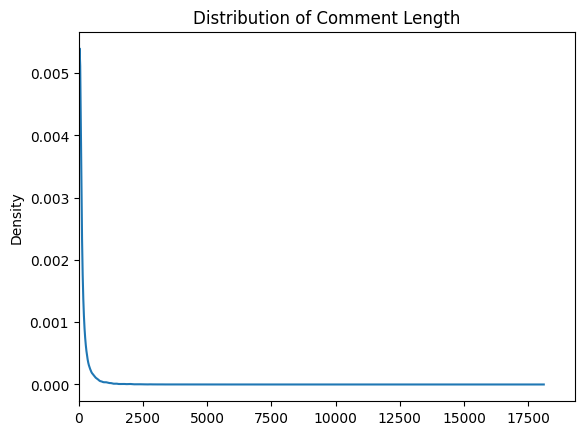

In [54]:
plt2 = doomer_df['text_len'].plot(kind='kde',
    title="Distribution of Comment Length",
    xlabel='Comment Length',
    xlim=0)

In [66]:
lonely_comments = doomer_comments[doomer_comments['body'].str.contains('lonely')]


In [69]:
lonely_posts = doomer_posts[doomer_posts['selftext'].str.contains('lonely')]